# "COVID-19 - Dashboard overview"
> Or maybe a poster generator for the macabre data junkie, updated daily

- comments: true
- author: Caglar Cakan
- categories: [covid19]
- permalink: /covid-dashboard/
- image: images/icon_covid_dashboard.png
- license: Creative Commons

In [1]:
#hide_input
import datetime
print("This page was last built on", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

This page was last built on 05.05.20 11:28:05


**Colors:** If the last reported cases are < 25% of the maximum, the data is shown in green. Else, if the last cases are > 75% of the maximum, the data is shown in red. Else, grey.

**Preprocessing:**
The number of new cases per day is averaged using a 10-day rolling window. Data is shown from the day of the 100th positive case until today. Countries are included if they have at least 1000 cases and at least 100 deaths. Countries are sorted by total number of cases. 

**Data:** The data is pulled from the COVID-19 Data Repository by Johns Hopkins CSSE

**Tools:** Python and Matplotlib, updated daily

**Versions (05/05/20):**
* [Color neural](https://i.imgur.com/jnjOG1z.png) version for folks who prefer other colors than red and green
* [Alphabetically sorted](https://i.imgur.com/HP2N3GK.png)
* [Larger version](https://i.imgur.com/4rWGRwT.png) with less filtering and many more countries **including Australia and New Zealand**
* [Alphabetical and large](https://i.imgur.com/w2DUkJe.png)

In [2]:
#hide
import numpy as np

import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

import requests
import io

from countryinfo import CountryInfo

In [3]:
#hide
import matplotlib
matplotlib.rc_file('mplstyles/dark.mplstyle')

In [4]:
#hide
from matplotlib import font_manager as fm, rcParams
prop = fm.FontProperties(fname="mplstyles/VeraMono.ttf")

In [5]:
#hide
def load_timeseries(name, 
                    base_url='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_covid19_{name}_global.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'

    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Fix South Korea
    df.loc[df.country =='Korea, South', 'country'] = 'South Korea'
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = (df.groupby(["date", "country", "type"])
          .sum()
          .reset_index()
          .sort_values(["country", "date"])
          .set_index("date"))
    return df

In [6]:
#hide

def get_countries_with_min_cases_for_df(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)
           ].sort_values(by=by, ascending=False)
    countries = countries['country'].values
    return countries

def get_countries_with_min_cases(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)].sort_values(by=by, ascending=False)
    countries = countries['country'].unique()
    return countries

def filter_cases(df_cases, by='cases', min_cases = 10, since_cases=None):
    countries = get_countries_with_min_cases_for_df(df_cases, by, min_cases)
    if since_cases is None:
        SINCE_CASES_NUM = 100
    else:
        SINCE_CASES_NUM = since_cases
        
    COL_X = f'Days since case {SINCE_CASES_NUM}'
    dff2 = df_cases[df_cases['country'].isin(countries)].copy()
    dff2['date'] = dff2.index
    days_since = (dff2.assign(F=dff2[by].ge(SINCE_CASES_NUM))
                  .set_index('date')
                  .groupby('country')['F'].transform('idxmax'))
    dff2[COL_X] = (dff2['date'] - days_since.values).dt.days.values
    dff2 = dff2[dff2[COL_X].ge(0)]
    return dff2

In [7]:
#hide
df_deaths = load_timeseries("deaths")
df_confirmed = load_timeseries("confirmed")

# concatenate both timeseries
df_cases = pd.concat((df_confirmed, df_deaths), axis=1)
df_cases.columns = ['country', 'type', 'confirmed', 'country', 'type', 'deaths']
df_cases = df_cases.loc[:,~df_cases.columns.duplicated()]

In [8]:
#hide
# create diffs
df_cases['new_deaths'] = df_cases.deaths.diff()
# flatten artifacts from one country to the next
df_cases.loc[df_cases['new_deaths']<0, 'new_deaths'] = 0
df_cases['new_confirmed'] = df_cases.confirmed.diff()
df_cases.loc[df_cases['new_confirmed']<0, 'new_confirmed'] = 0

In [9]:
#hide
MIN_CASES = 1000
SINCE_CASES = 100
dff2 = filter_cases(df_cases, 'confirmed', MIN_CASES, SINCE_CASES)

In [10]:
#hide
dff2.country.unique()

array(['Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus',
       'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Bulgaria', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Ghana', 'Greece', 'Guinea',
       'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kazakhstan', 'Kuwait', 'Lithuania', 'Luxembourg', 'Malaysia',
       'Mexico', 'Moldova', 'Morocco', 'Netherlands', 'New Zealand',
       'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Pakistan',
       'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar',
       'Romania', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Singapore', 'Slovakia', 'Slovenia

In [11]:
#hide
MIN_DEATHS = 100
get_countries_with_min_cases(dff2, 'deaths', MIN_DEATHS)

array(['US', 'Italy', 'United Kingdom', 'Spain', 'France', 'Belgium',
       'Brazil', 'Germany', 'Iran', 'Netherlands', 'China', 'Canada',
       'Turkey', 'Sweden', 'Mexico', 'Switzerland', 'Ecuador', 'India',
       'Russia', 'Peru', 'Ireland', 'Portugal', 'Indonesia', 'Romania',
       'Poland', 'Philippines', 'Austria', 'Japan', 'Denmark', 'Pakistan',
       'Algeria', 'Egypt', 'Colombia', 'Hungary', 'Dominican Republic',
       'Ukraine', 'Chile', 'Argentina', 'South Korea', 'Czechia',
       'Finland', 'Israel', 'Norway', 'Panama', 'Serbia', 'Saudi Arabia',
       'Bangladesh', 'Morocco', 'Greece', 'South Africa',
       'United Arab Emirates', 'Moldova', 'Malaysia', 'Belarus'],
      dtype=object)

In [12]:
#hide
ignore = []#["China"]

countries = get_countries_with_min_cases(dff2, 'deaths', MIN_DEATHS)[:]
countries = [c for c in countries if c not in ignore]
print(len(countries))
#countries.sort()

54


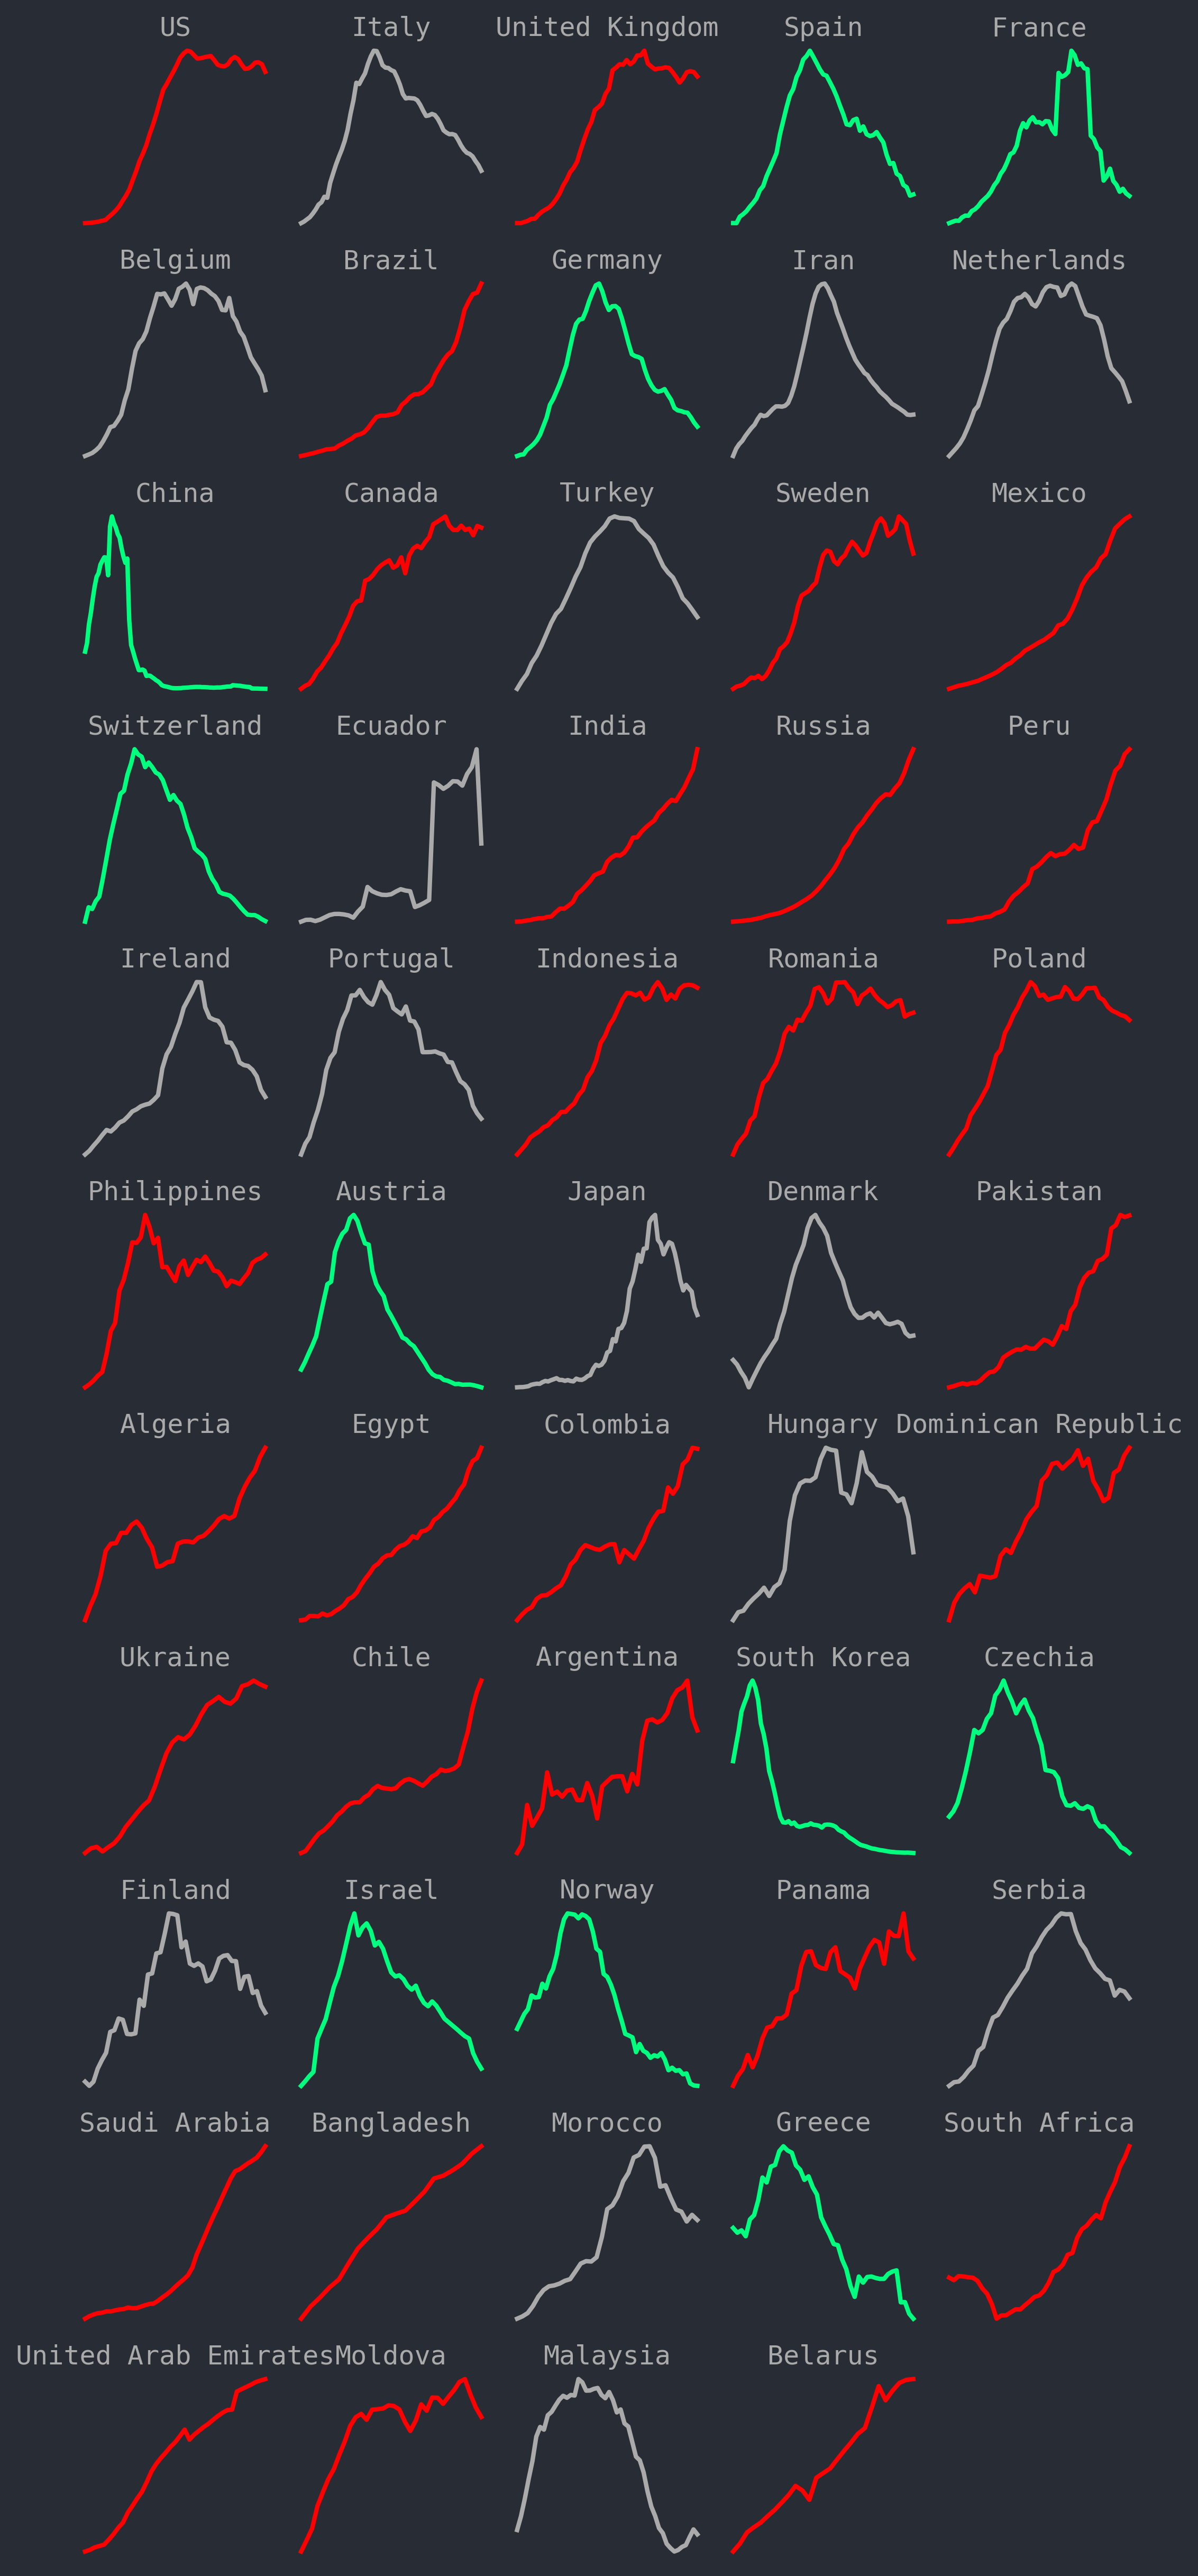

In [15]:
#hide_input
import math

ROLLING_MEAN_DAYS = 10

ncols = 5
nrows = math.ceil(len(countries)/ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*1.5, nrows*1.5), dpi=300)
plt.tight_layout(h_pad=0, w_pad=-2)

for i, str_country in enumerate(countries):
    df_cases_country = dff2[dff2['country']==str_country]      
    
    r = int(i / ncols)
    c = i % ncols
    axs = ax[r, c]
    
    
    #axs.bar(df_cases_country.index, df_cases_country.new_confirmed, lw=4, label=f"Confirmed cases", color='k')
    rolling_mean = df_cases_country.new_confirmed.rolling(ROLLING_MEAN_DAYS).mean()
    
    color_white = "#AAAAAA"
    color = color_white
    last_cases = rolling_mean.iloc[-1]
    last_ratio = last_cases/rolling_mean.max()
    #print(f"{str_country}: {100*last_ratio:.2f} % (max: {df_cases_country.new_confirmed.max()}, last: {last_cases})")
    
    if last_ratio < 0.25:
        #color='C1'
        color='springgreen'
    elif last_ratio > 0.75:
        #color='C4'
        color='red'
            
    axs.set_title(f"{str_country}", size=6, pad=3, color=color_white, fontproperties=prop)
    axs.plot(df_cases_country.index, rolling_mean, lw=2, label=f"Confirmed cases", color=color)
    
    axs.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every x months
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y')) 

    
# turn off axis
for r in range(nrows):
    for c in range(ncols):
        ax[r, c].axis('off')

import matplotlib
bob = matplotlib.transforms.Bbox([[0.5, ncols-3.2], [4.7, ncols-0.16]])
#plt.savefig("../images/icon_covid_dashboard.png", bbox_inches=bob)        
# #plt.tight_layout(h_pad=0, w_pad=-1)

plt.show();